In [1]:
from openpiv import tools, pyprocess, scaling, validation, filters
import matplotlib.pyplot as plt
import numpy as np

import imageio
import pathlib

import os
import glob


import warnings
warnings.filterwarnings('ignore')


In [157]:


# path = "/home/moritz/BWSyncAndShare/Studium/Masterarbeit/MA-Code/Animations"        ## Laptop
path = "/home/moritz-vogel/bwSyncShare/Studium/Masterarbeit/MA-Code/Animations"     ## Hiwirechner


ex = "res_800"
reader = tools.imread  # imageio.imread / tools.imread


expart = ex + "_partOnly"
image_files_whole = sorted(glob.glob(os.path.join(path, ex, "*00*.tiff")))
frames_whole = [reader(img) for img in image_files_whole]
image_files_part= sorted(glob.glob(os.path.join(path, expart, "*00*.tiff")))
frames_part = [reader(img) for img in image_files_part]
# frames = [imageio.imread(img) for img in image_files]

In [160]:
frames = frames_whole

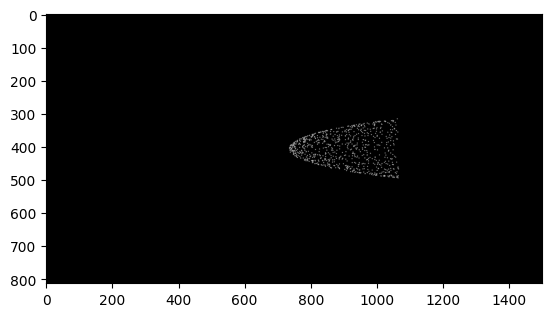

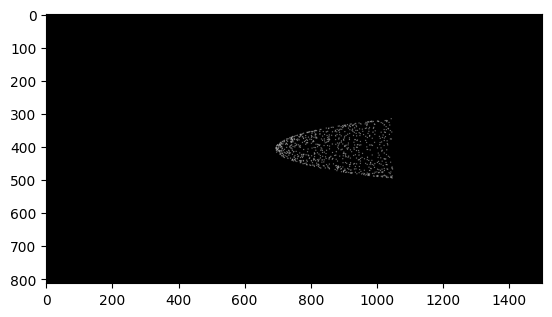

In [213]:

i = 15

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(frames[i], cmap = plt.cm.gray)

fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.imshow(frames[i+1], cmap = plt.cm.gray)

In [225]:
sea_exp = 6

winsize = int(2**sea_exp)            # pixels, interrogation window size in frame A
overlap = int(2**(sea_exp - 1))      # pixels, 50% overlap
searchsize = int(2**(sea_exp))   # pixels, search area size in frame B
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frames[i].astype(np.int32),
    frames[i+1].astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

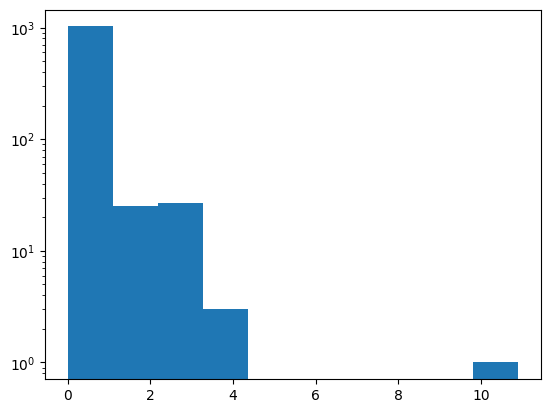

In [226]:
doInvalidMask = 1
doFilter = 1
doScaling = 0


x, y = pyprocess.get_coordinates(
    image_size=frames[i].shape,
    search_area_size=searchsize,
    overlap=overlap,
)

u2, v2 = u0, v0
u3, v3 = u0, v0
plt.hist(sig2noise.flatten(), log = True)


if doInvalidMask:
    invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold = 1.1,
    )

if doFilter:
    u2, v2 = filters.replace_outliers(
        u0, v0,
        invalid_mask,
        method='localmean',
        max_iter=3,
        kernel_size=3,
    )

if doScaling:
    x, y, u3, v3 = scaling.uniform(
        x, y, u2, v2, #convert x,y to mm  #convert u,v to mm/sec
        scaling_factor = 1,  # 96.52 pixels/millimeter
    )

    # 0,0 shall be bottom left, positive rotation rate is counterclockwise
    x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

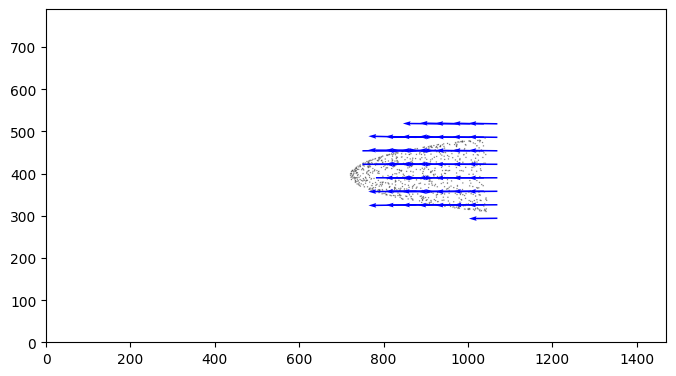

In [227]:
if doInvalidMask:
    tools.save('exp1_001.txt' , x, y, u3, v3, invalid_mask)
else:
    tools.save('exp1_001.txt' , x, y, u3, v3)




fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    pathlib.Path('exp1_001.txt'),
    ax=ax, 
    scaling_factor=1, # 96.52
    scale=2e+4, # scale defines here the arrow length
    #width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= os.path.join(path, ex, ex+f".{i:04d}.tiff")
    # image_name= os.path.join(path,"canal.tiff")
);


